<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "NP-L6"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/NP-L6/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


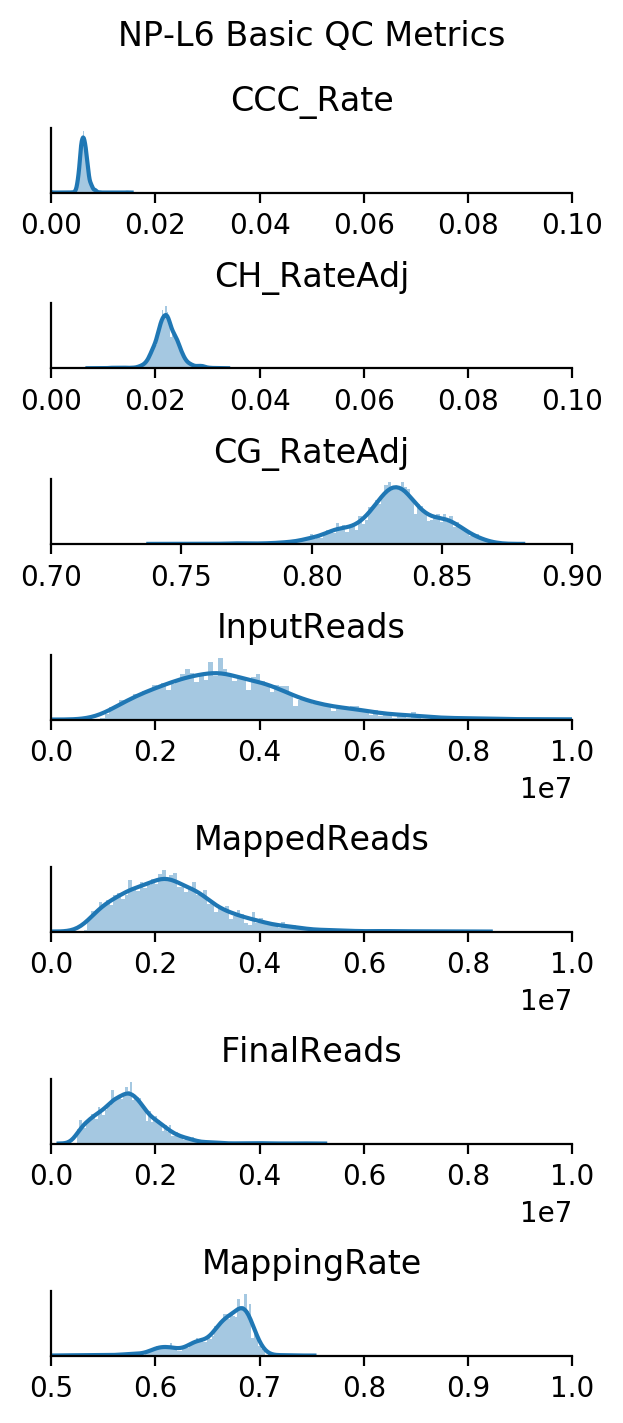

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

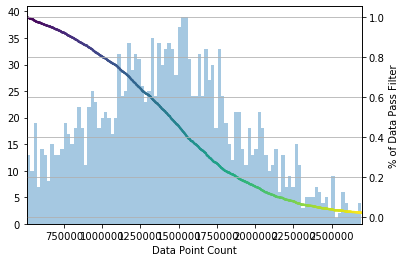

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1819/1819 (100.0%)
CG_RateAdj passed 1819/1819 (100.0%)
CH_RateAdj passed 1819/1819 (100.0%)
FinalReads passed 1819/1819 (100.0%)
MappingRate passed 1819/1819 (100.0%)
Overall passed 1819/1819 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 22
171207 32
171212 8
171213 39
180104 42
180109 2
180119 45
180122 67
180123 86
180129 43
180130 64
180205 65
180206 63
180213 37
180220 3
180222 8
180226 14
180227 10
180305 38
180306 79
180312 66
180320 7
180326 6
180329 3
180402 3
180405 1
180409 28
180410 34
180412 41
180416 41
180417 23
180419 15
180423 31
180424 19
180426 26
180430 28
180501 48
180514 24
180529 22
180605 40
180612 26
180917 10
181002 22
181009 4
181022 31
181023 41
181204 22
181210 26
190108 25
190117 43
190122 48
190124 19
190131 5
190205 52
190212 4
190214 46
190219 4
190305 66
190307 30
190625 10
190627 12


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 236 61.5%
ad002 234 60.9%
ad004 218 56.8%
ad006 230 59.9%
ad007 214 55.7%
ad008 242 63.0%
ad010 233 60.7%
ad012 212 55.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_135,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.007693,0.806861,0.805364,0.035217,0.027738,1654479.0,4242320,2762984.0,10E,...,14.011536,-23.597385,37.516563,25.946799,NP-L6,25.833487,3.810488,-8.360947,-23.706875,True
10E_M_1614,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007064,0.809248,0.807891,0.031460,0.024570,2190672.0,6467888,4259737.0,10E,...,14.024504,-23.363295,37.824178,25.781038,NP-L6,25.410795,3.615465,-7.734582,-23.002058,True
10E_M_1882,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007010,0.816145,0.814847,0.032605,0.025775,2399546.0,7437820,4948836.0,10E,...,13.964697,-23.456888,37.799983,25.806030,NP-L6,25.564655,3.469779,-7.753855,-23.198043,True
10E_M_1959,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007086,0.798691,0.797255,0.032304,0.025397,1689099.0,5089912,3262583.0,10E,...,14.097324,-23.567171,37.527295,25.926758,NP-L6,25.756361,3.711157,-8.341860,-23.716008,True
10E_M_1982,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006872,0.805080,0.803732,0.031300,0.024597,2014135.0,5741712,3754082.0,10E,...,14.912744,-23.208838,36.907563,25.742771,NP-L6,25.784243,4.804650,-9.783056,-22.562799,True
10E_M_2004,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006689,0.805267,0.803955,0.031433,0.024910,2540241.0,8549204,5424614.0,10E,...,13.928839,-23.460497,37.730135,25.760564,NP-L6,25.626055,3.670109,-8.185245,-22.905522,True
10E_M_2036,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007197,0.818820,0.817506,0.030976,0.023951,2268365.0,7035652,4630909.0,10E,...,14.154867,-23.283592,37.959775,25.695302,NP-L6,25.396086,3.468570,-7.217845,-22.486761,True
10E_M_2294,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.005936,0.795678,0.794458,0.024287,0.018461,1476466.0,3907630,2606727.0,10E,...,13.787937,-23.626354,37.807572,25.817074,NP-L6,25.552057,3.361966,-7.229368,-23.298793,True
10E_M_2407,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007261,0.808975,0.807578,0.034008,0.026944,2087397.0,5977574,3958808.0,10E,...,13.987497,-23.490231,37.659657,25.759177,NP-L6,25.692154,3.741114,-8.350377,-22.909273,True
